## Libraries

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import plotly.express as px
from torch import nn
import pandas as pd
import torch

## Generating data

In [223]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.025, random_state=42)

In [224]:
print('X samples:', X[:5])
print('y samples:', y[:5])

X samples: [[ 0.75725609  0.22767948]
 [-0.76169053  0.14940069]
 [-0.81177524  0.16111279]
 [-0.38487951  0.69804592]
 [ 0.441359   -0.8971704 ]]
y samples: [1 1 1 1 0]


In [225]:
df = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1], 
    'label': y
})
df.head()

,X1,X2,label
0,0.757256,0.227679,1
1,-0.761691,0.149401,1
2,-0.811775,0.161113,1
3,-0.384880,0.698046,1
4,0.441359,-0.897170,0


In [226]:
df['label'].value_counts()

label
1    500
0    500
Name: count, dtype: int64

## Plotting

In [227]:
px.scatter(x=df['X1'], y=df['X2'], color=df['label'])

## Data preparation

In [228]:
X.shape, y.shape

((1000, 2), (1000,))

In [229]:
print(X[0])
print(y[0])

[0.75725609 0.22767948]
1


In [230]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [231]:
X[0]

tensor([0.7573, 0.2277])

In [232]:
y[0]

tensor(1.)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## Making the model

In [234]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [235]:
class CirlceModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=13)
        self.layer2 = nn.Linear(in_features=13, out_features=13)
        self.layer3 = nn.Linear(in_features=13, out_features=1)
        self.relu = nn.Sigmoid()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model = CirlceModel().to(device)
print(model)

CirlceModel(
  (layer1): Linear(in_features=2, out_features=13, bias=True)
  (layer2): Linear(in_features=13, out_features=13, bias=True)
  (layer3): Linear(in_features=13, out_features=1, bias=True)
  (relu): Sigmoid()
)


In [236]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [237]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [238]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    
    # 2. Calculate loss and accuracy
    loss = loss_func(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_func(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69359, Accuracy: 50.12% | Test Loss: 0.69404, Test Accuracy: 49.50%
Epoch: 100 | Loss: 0.69287, Accuracy: 51.25% | Test Loss: 0.69391, Test Accuracy: 49.00%
Epoch: 200 | Loss: 0.69240, Accuracy: 51.00% | Test Loss: 0.69462, Test Accuracy: 49.00%
Epoch: 300 | Loss: 0.69108, Accuracy: 51.88% | Test Loss: 0.69481, Test Accuracy: 50.50%
Epoch: 400 | Loss: 0.68373, Accuracy: 56.62% | Test Loss: 0.68906, Test Accuracy: 50.00%
Epoch: 500 | Loss: 0.65043, Accuracy: 81.50% | Test Loss: 0.65937, Test Accuracy: 74.50%
Epoch: 600 | Loss: 0.57976, Accuracy: 91.62% | Test Loss: 0.59348, Test Accuracy: 89.00%
Epoch: 700 | Loss: 0.48424, Accuracy: 98.25% | Test Loss: 0.49929, Test Accuracy: 96.50%
Epoch: 800 | Loss: 0.38347, Accuracy: 99.88% | Test Loss: 0.39628, Test Accuracy: 99.50%
Epoch: 900 | Loss: 0.29618, Accuracy: 100.00% | Test Loss: 0.30726, Test Accuracy: 99.50%


In [239]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

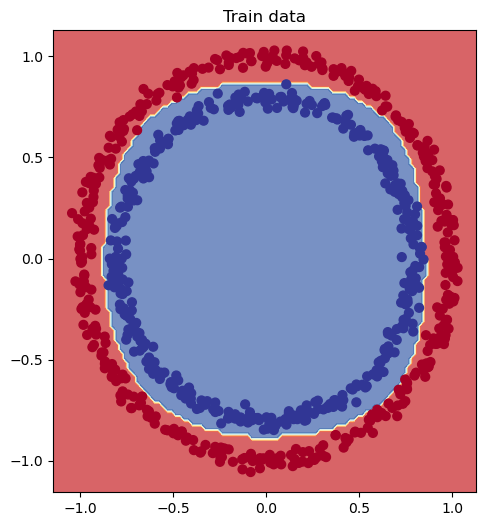

In [240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train data")
plot_decision_boundary(model, X_train, y_train)

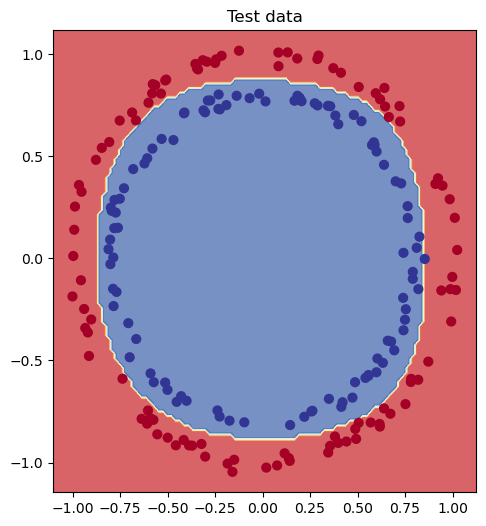

In [241]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Test data")
plot_decision_boundary(model, X_test, y_test)